In [32]:
%matplotlib inline
from utils import *
import matplotlib.colors as mcolors
import pickle
import os
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter

## Neuron params

In [33]:
# Default params
R_m = 142 * 1e6                                     # 142 MΩ
V_th = 15 * 1e-3                                    # 15 mV
tau_m = 24 * 1e-3                                   # 24 ms                           
I_osc = 40 * 1e-12                                  # 40 pA
range_frac = 0.6                                    # fraction of range to use
tau_s = 200 * 1e-3                                  # 200 ms of decay time constant of signal
f_lims = [1, 50]
eta_lims = [1e-10, 0.3]

In [3]:
def load_data(file_path):
    with open(file_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

# Specify the directory containing the pickle files
directory = 'cluster/Data/'

# Initialize lists to store the aggregated data
means_theo = []
variances_theo = []
means_emp = []
variances_emp = []
MI = []

# Loop through all files in the specified directory
for filename in os.listdir(directory):
    if filename.endswith('.pickle'):
        file_path = os.path.join(directory, filename)
        data = load_data(file_path)
        
        means_theo.append(data["means_theo"])
        variances_theo.append(data["variances_theo"])
        means_emp.append(data["means_emp"])
        variances_emp.append(data["variances_emp"])
        MI.append(data["MI"])

# Convert lists to full matrices (numpy arrays)
means_theo = np.array(means_theo)
variances_theo = np.array(variances_theo)
means_emp = np.array(means_emp)
variances_emp = np.array(variances_emp)
MI = np.array(MI)

In [4]:
res = 200
means_theo = means_theo.reshape(res, res, 10)
variances_theo = variances_theo.reshape(res, res, 10)
means_emp = means_emp.reshape(res, res, 10)
variances_emp = variances_emp.reshape(res, res, 10)
mis_emp = MI.reshape(res, res)

In [5]:
# Display the shapes of the full matrices
print(f"means_theo_matrix shape: {means_theo.shape}")
print(f"variances_theo_matrix shape: {variances_theo.shape}")
print(f"means_emp_matrix shape: {means_emp.shape}")
print(f"variances_emp_matrix shape: {variances_emp.shape}")
print(f"MI_matrix shape: {mis_emp.shape}")

means_theo_matrix shape: (200, 200, 10)
variances_theo_matrix shape: (200, 200, 10)
means_emp_matrix shape: (200, 200, 10)
variances_emp_matrix shape: (200, 200, 10)
MI_matrix shape: (200, 200)


In [6]:
M = 10
res = 200
fs = np.linspace(f_lims[0], f_lims[1], res)
etas = np.linspace(eta_lims[0], eta_lims[1], res)
mis_theo = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N=1)
        mis_theo[i, j] = approx_mi(means, variances)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [7]:
info_rate_emp_norm = get_R(mis_emp, fs, tau_s, corr=True, norm=True)
info_rate_theo_norm = get_R(mis_theo, fs, tau_s, corr=True, norm=True)

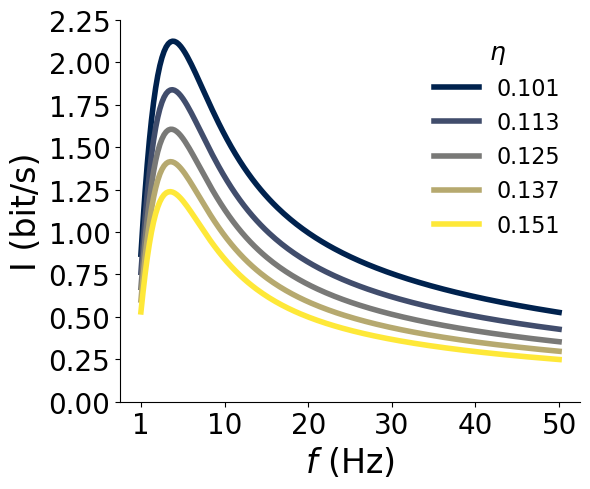

In [19]:
plt.figure(figsize=(6, 5))

# Calculate information rate
info_rate_theo = get_R(mis_theo, fs, tau_s, corr=True, norm=False)
noise_range_idx = np.linspace(67, 100, 5).astype(int)

# Choose a colormap that reflects increasing noise, e.g., viridis or plasma
cmap = plt.cm.cividis
norm = plt.Normalize(vmin=noise_range_idx.min(), vmax=noise_range_idx.max())

for noise_idx in noise_range_idx:
    color = cmap(norm(noise_idx))
    plt.plot(info_rate_theo[noise_idx], label=f'{etas[noise_idx]:.3f}', linewidth=4, color=color)

# Customize the x and y ticks
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=24)
plt.yticks(fontsize=20)
plt.ylabel('I (bit/s)', fontsize=24)

# Set the y-axis limit
plt.ylim(0, 2.25)

# Add legend with a title
legend = plt.legend(frameon=False, title=r'$\eta$', fontsize=16, title_fontsize=18)

# Despine and show plot
sb.despine()
plt.tight_layout()
plt.savefig('plots/fig6/fig6_SupplMutualInfo.svg', dpi=600)
plt.show()

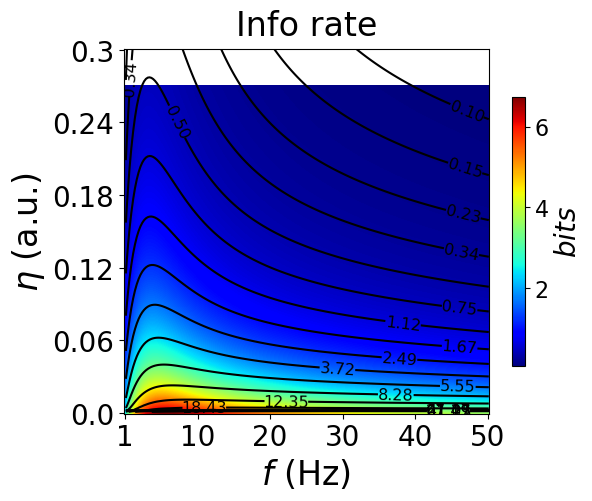

In [24]:
plt.figure(figsize=(6, 6))

# Simulations plot
plt.title('Info rate', fontsize=24, pad=10)
img1 = plt.imshow(info_rate_theo[20:], origin='lower', cmap='jet', interpolation='lanczos')
contour_levels = np.logspace(np.log10(info_rate_theo.min()), np.log10(info_rate_theo.max()), num=20)
contours1 = plt.contour(info_rate_theo, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=24)
plt.ylabel('$\eta$ (a.u.)', fontsize=24)
cbar = plt.colorbar(img1, label=r'$I_{norm.}$', shrink=.5)
cbar.set_label(r'$bits$', fontsize=20)
cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick fontsize
plt.tight_layout()

#plt.savefig('plots/fig6/fig6_varianceEstim.svg', dpi=600)

plt.show()

## Mutual info

C:\Users\Afernandez\AppData\Local\Temp\ipykernel_32008\4200451707.py:34: RuntimeWarning: divide by zero encountered in log10
  contour_levels_emp = np.logspace(np.log10(vmin_emp), np.log10(vmax_emp), num=num_levels)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
C:\Users\Afernandez\AppData\Local\Temp\ipykernel_32008\4200451707.py:35: RuntimeWarning: divide by zero encountered in log10
  contour_levels_theo = np.logspace(np.log10(vmin_theo), np.log10(vmax_theo), num=num_levels)


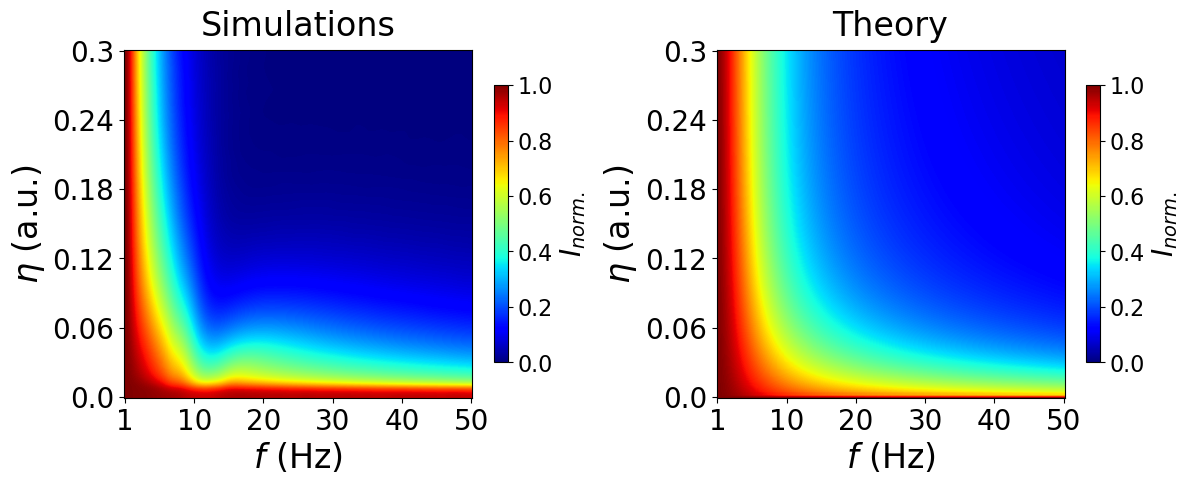

In [8]:
# Apply Gaussian smoothing to the data
sigma = 3  # Standard deviation for Gaussian kernel, adjust as needed
mis_emp_smooth = gaussian_filter(mis_emp, sigma=sigma)
mis_theo_smooth = gaussian_filter(mis_theo, sigma=1e-10)

# Frequency-normalized
mis_emp_smooth_norm = np.zeros_like(mis_emp_smooth)  
for index, row in enumerate(mis_emp_smooth):
    mis_emp_smooth_norm[index, :] = row/np.max(row)
    
mis_theo_smooth_norm = np.zeros_like(mis_theo_smooth)  
for index, row in enumerate(mis_theo_smooth):
    mis_theo_smooth_norm[index, :] = row/np.max(row)

# Determine the common color scale range
#vmin = min(np.min(mis_emp_smooth), np.min(mis_theo_smooth))
#vmax = max(np.max(mis_emp_smooth), np.max(mis_theo_smooth))

# Define contour levels using a power law
#num_levels = 12
#power = 2  # Adjust power to control spacing between levels
#contour_levels = np.linspace(0, 1, num=num_levels)**power * (vmax - vmin) + vmin

# Determine the color scale range for each dataset in log space
#vmin_emp = mis_emp_smooth_norm[mis_emp_smooth_norm > 0].min()
vmin_emp = 0
vmax_emp = mis_emp_smooth_norm.max()
#vmin_theo = mis_theo_smooth_norm[mis_theo_smooth_norm > 0].min()
vmin_theo = 0
vmax_theo = mis_theo_smooth_norm.max()

# Define contour levels for each dataset in the original scale
num_levels = 12
contour_levels_emp = np.logspace(np.log10(vmin_emp), np.log10(vmax_emp), num=num_levels)
contour_levels_theo = np.logspace(np.log10(vmin_theo), np.log10(vmax_theo), num=num_levels)





plt.figure(figsize=(12, 6))

# Simulations plot
plt.subplot(121)
plt.title('Simulations', fontsize=24, pad=10)
img1 = plt.imshow(mis_emp_smooth_norm, origin='lower', cmap='jet', vmin=vmin_emp, vmax=vmax_emp, interpolation='lanczos')
contours1 = plt.contour(mis_emp_smooth_norm, levels=contour_levels_emp, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=24)
plt.ylabel('$\eta$ (a.u.)', fontsize=24)
cbar = plt.colorbar(img1, label=r'$I_{norm.}$', shrink=.5)
cbar.set_label(r'$I_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick fontsize

# Theory plot
plt.subplot(122)
plt.title('Theory', fontsize=24, pad=10)
img2 = plt.imshow(mis_theo_smooth_norm, origin='lower', cmap='jet', vmin=vmin_theo, vmax=vmax_theo, interpolation='lanczos')
contours2 = plt.contour(mis_theo_smooth_norm, levels=contour_levels_theo, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours2, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=24)
plt.ylabel('$\eta$ (a.u.)', fontsize=24)
cbar = plt.colorbar(img2, label=r'$I_{norm.}$', shrink=.5)
cbar.set_label(r'$I_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick fontsize

plt.tight_layout()

#plt.savefig('plots/fig6/fig6_varianceEstim.svg', dpi=600)

plt.show()

## Mutual info and info rate

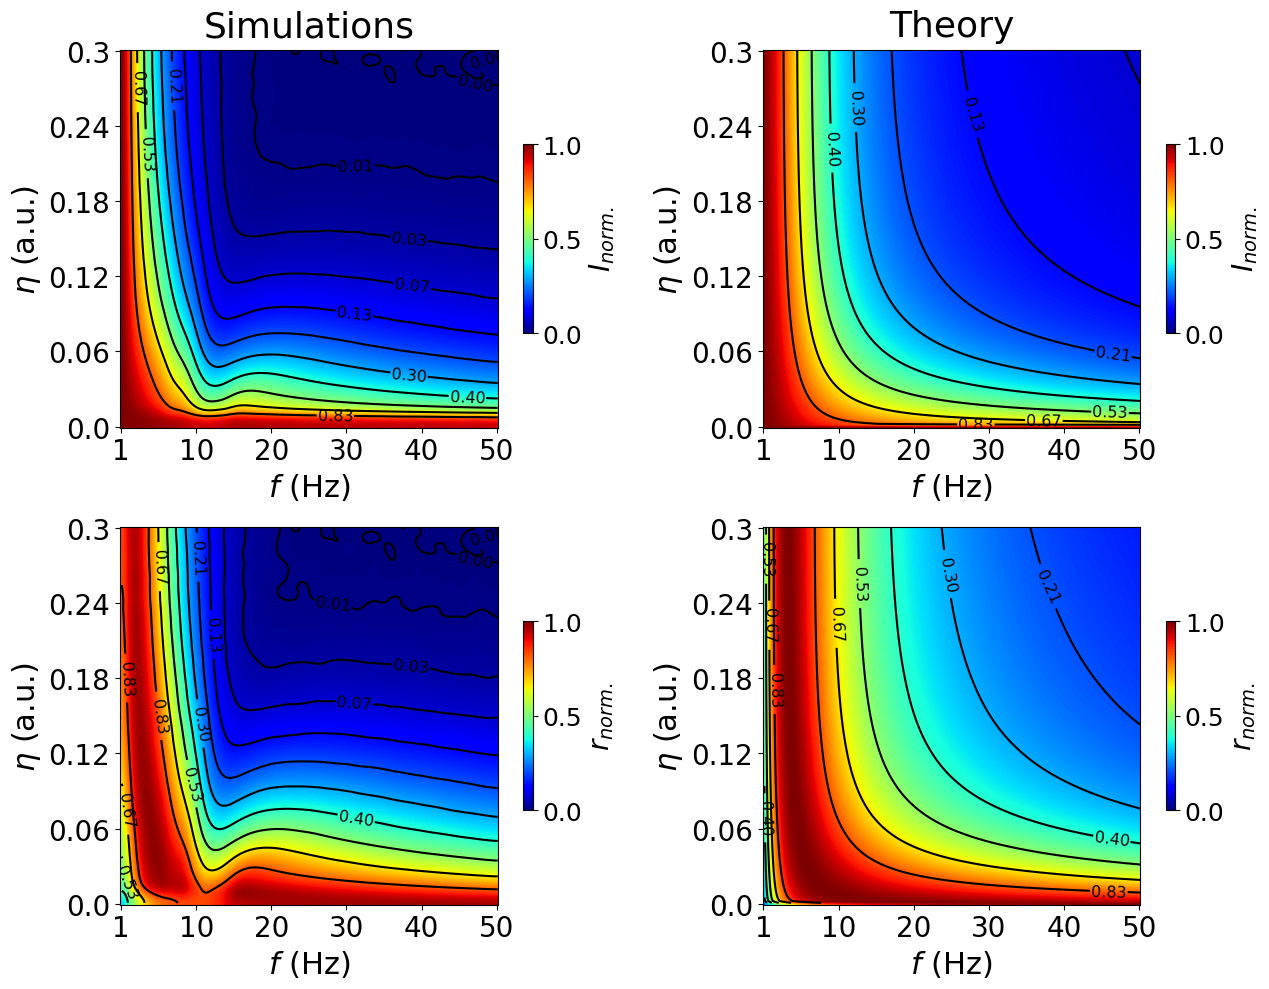

In [9]:
# Apply Gaussian smoothing to the data
sigma = 3  # Standard deviation for Gaussian kernel, adjust as needed
mis_emp_smooth = gaussian_filter(mis_emp, sigma=sigma)
mis_theo_smooth = gaussian_filter(mis_theo, sigma=1e-10)

# Frequency-normalized
mis_emp_smooth_norm = np.zeros_like(mis_emp_smooth)  
for index, row in enumerate(mis_emp_smooth):
    mis_emp_smooth_norm[index, :] = row/np.max(row)
    
mis_theo_smooth_norm = np.zeros_like(mis_theo_smooth)  
for index, row in enumerate(mis_theo_smooth):
    mis_theo_smooth_norm[index, :] = row/np.max(row)

# Determine the common color scale range
vmin = 0
vmax = 1

# Define contour levels using a power law
num_levels = 12
power = 2  # Adjust power to control spacing between levels
contour_levels = np.linspace(0, 1, num=num_levels)**power * (vmax - vmin) + vmin


plt.figure(figsize=(13, 10))

# Simulations plot
plt.subplot(221)
plt.title('Simulations', fontsize=26, pad=10)
img1 = plt.imshow(mis_emp_smooth_norm, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours1 = plt.contour(mis_emp_smooth_norm, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=22)
plt.ylabel('$\eta$ (a.u.)', fontsize=22)
cbar = plt.colorbar(img1, label=r'$I_{norm.}$', shrink=.5)
cbar.set_label(r'$I_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize

# Theory plot
plt.subplot(222)
plt.title('Theory', fontsize=26, pad=10)
img2 = plt.imshow(mis_theo_smooth_norm, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours2 = plt.contour(mis_theo_smooth_norm, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours2, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=22)
plt.ylabel('$\eta$ (a.u.)', fontsize=22)
cbar = plt.colorbar(img2, label=r'$I_{norm.}$', shrink=.5)
cbar.set_label(r'$I_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize




# Apply Gaussian smoothing to the data
sigma = 3  # Standard deviation for Gaussian kernel, adjust as needed
info_rate_emp_norm_smooth = gaussian_filter(info_rate_emp_norm, sigma=sigma)
info_rate_theo_norm_smooth = gaussian_filter(info_rate_theo_norm, sigma=1e-10)

# Determine the common color scale range
vmin = 0
vmax = 1

# Define contour levels using a power law
num_levels = 12
power = 2  # Adjust power to control spacing between levels
contour_levels = np.linspace(0, 1, num=num_levels)**power * (vmax - vmin) + vmin


# Simulations plot
plt.subplot(223)
#plt.title('Simulations', fontsize=24, pad=10)
img1 = plt.imshow(info_rate_emp_norm_smooth, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours1 = plt.contour(info_rate_emp_norm_smooth, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=22)
plt.ylabel('$\eta$ (a.u.)', fontsize=22)
cbar = plt.colorbar(img1, label=r'$r_{norm.}$', shrink=.5)
cbar.set_label(r'$r_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize

# Theory plot
plt.subplot(224)
#plt.title('Theory', fontsize=24, pad=10)
img2 = plt.imshow(info_rate_theo_norm_smooth, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours2 = plt.contour(info_rate_theo_norm_smooth, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours2, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=22)
plt.ylabel('$\eta$ (a.u.)', fontsize=22)
cbar = plt.colorbar(img2, label=r'$r_{norm.}$', shrink=.5)
cbar.set_label(r'$r_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize


plt.tight_layout()

#plt.savefig('plots/fig6/fig6_MI_and_R.svg', dpi=600)

plt.show()

## Info rate (plot for paper)

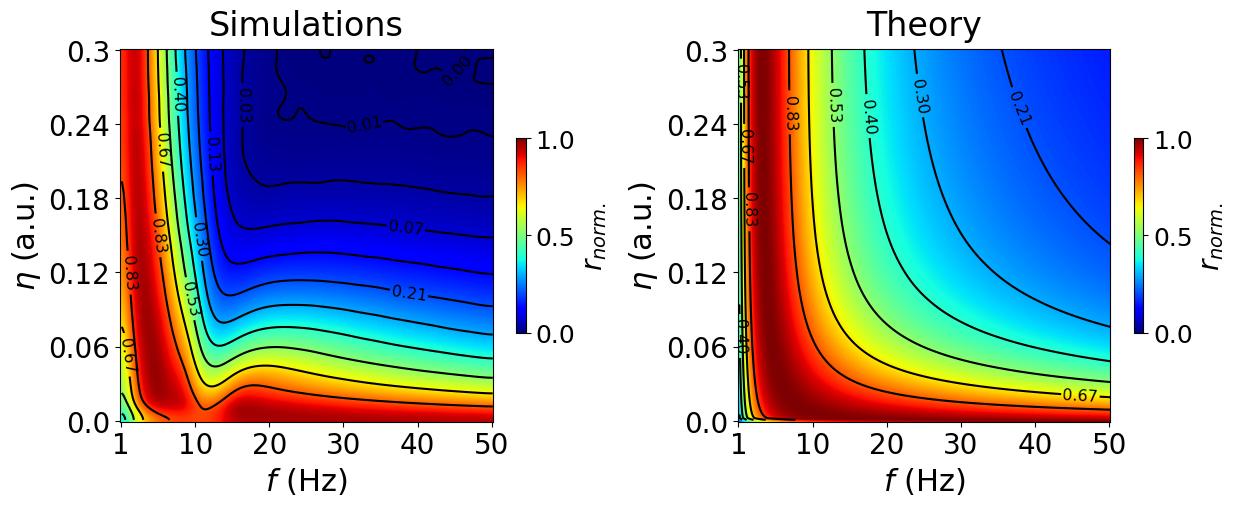

In [8]:
plt.figure(figsize=(12.5, 5))

# Apply Gaussian smoothing to the data
sigma = 4  # Standard deviation for Gaussian kernel, adjust as needed
info_rate_emp_norm_smooth = gaussian_filter(info_rate_emp_norm, sigma=sigma)
info_rate_theo_norm_smooth = gaussian_filter(info_rate_theo_norm, sigma=1e-10)

# Determine the common color scale range
vmin = 0
vmax = 1

# Define contour levels using a power law
num_levels = 12
power = 2  # Adjust power to control spacing between levels
contour_levels = np.linspace(0, 1, num=num_levels)**power * (vmax - vmin) + vmin


# Simulations plot
plt.subplot(121)
plt.title('Simulations', fontsize=24, pad=10)
img1 = plt.imshow(info_rate_emp_norm_smooth, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours1 = plt.contour(info_rate_emp_norm_smooth, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=22)
plt.ylabel('$\eta$ (a.u.)', fontsize=22)
cbar = plt.colorbar(img1, label=r'$r_{norm.}$', shrink=.5)
cbar.set_label(r'$r_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize

# Theory plot
plt.subplot(122)
plt.title('Theory', fontsize=24, pad=10)
img2 = plt.imshow(info_rate_theo_norm_smooth, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
contours2 = plt.contour(info_rate_theo_norm_smooth, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours2, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
plt.xlabel('$f$ (Hz)', fontsize=22)
plt.ylabel('$\eta$ (a.u.)', fontsize=22)
cbar = plt.colorbar(img2, label=r'$r_{norm.}$', shrink=.5)
cbar.set_label(r'$r_{norm.}$', fontsize=20)
cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize


plt.tight_layout()

plt.savefig('plots/fig6/fig6_R.svg', dpi=600)

plt.show()

## Supplementary

In [12]:
taus_s = np.array([20, 50, 100, 200, 500, 1000]) * 1e-3
info_rate_theo_norm_taus_s = []
for tau_s in taus_s:
    info_rate_theo_norm = get_R(mis_theo, fs, tau_s, corr=True, norm=True)
    info_rate_theo_norm_taus_s.append(info_rate_theo_norm)

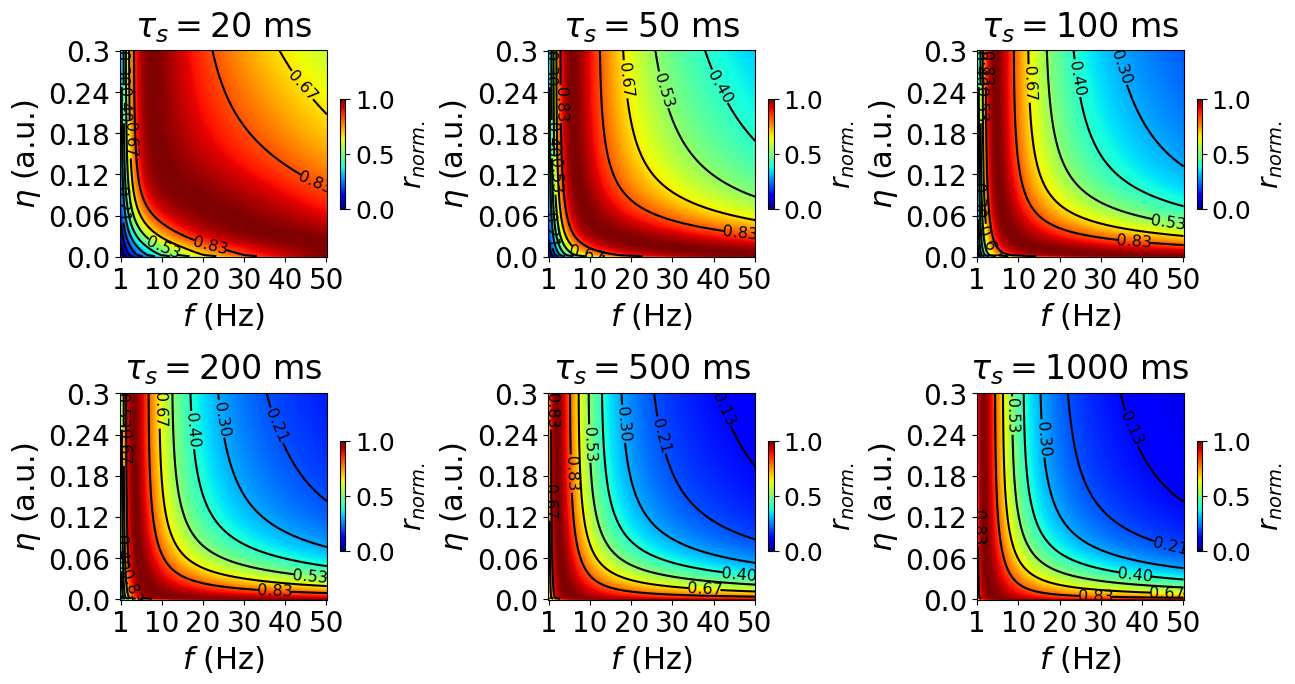

In [15]:
# Determine the common color scale range
vmin = 0
vmax = 1

# Define contour levels using a power law
num_levels = 12
power = 2  # Adjust power to control spacing between levels
contour_levels = np.linspace(0, 1, num=num_levels)**power * (vmax - vmin) + vmin

plt.figure(figsize=(13, 7))

for i, tau_s in enumerate(taus_s):
    plt.subplot(2,3,i+1)
    plt.title(r'$\tau_s=$'+str(int(tau_s*1e3))+' ms', fontsize=24, pad=10)
    img1 = plt.imshow(info_rate_theo_norm_taus_s[i], origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
    contours1 = plt.contour(info_rate_theo_norm_taus_s[i], levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
    plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
    plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
    plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
    plt.xlabel('$f$ (Hz)', fontsize=22)
    plt.ylabel('$\eta$ (a.u.)', fontsize=22)
    cbar = plt.colorbar(img1, label=r'$r_{norm.}$', shrink=.5)
    cbar.set_label(r'$r_{norm.}$', fontsize=20)
    cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize

plt.tight_layout()

# Save the figure
plt.savefig('plots/fig6/supplFig6_R_taus_s.svg', dpi=600)

# Show the plot
plt.show()

### Taus_m

In [3]:
M = 10
res = 200
fs = np.linspace(f_lims[0], f_lims[1], res)
etas = np.linspace(eta_lims[0], eta_lims[1], res)
taus_m = np.array([10, 20, 50, 100, 500, 1000]) * 1e-3
mis_theo = np.zeros((6,res,res))
for z, tau_m in enumerate(taus_m):
    print(z)
    for i, eta in enumerate(etas):
        for j, f in enumerate(fs):
            means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N=1)
            mis_theo[z,i,j] = approx_mi(means, variances)

0
1
2
3
4
5


In [26]:
info_rate_theo_norm_taus_m = []
tau_s = 100 * 1e-3
for i, _ in enumerate(taus_m):
    info_rate_theo_norm = get_R(mis_theo[i], fs, tau_s, corr=True, norm=True)
    info_rate_theo_norm_taus_m.append(info_rate_theo_norm)

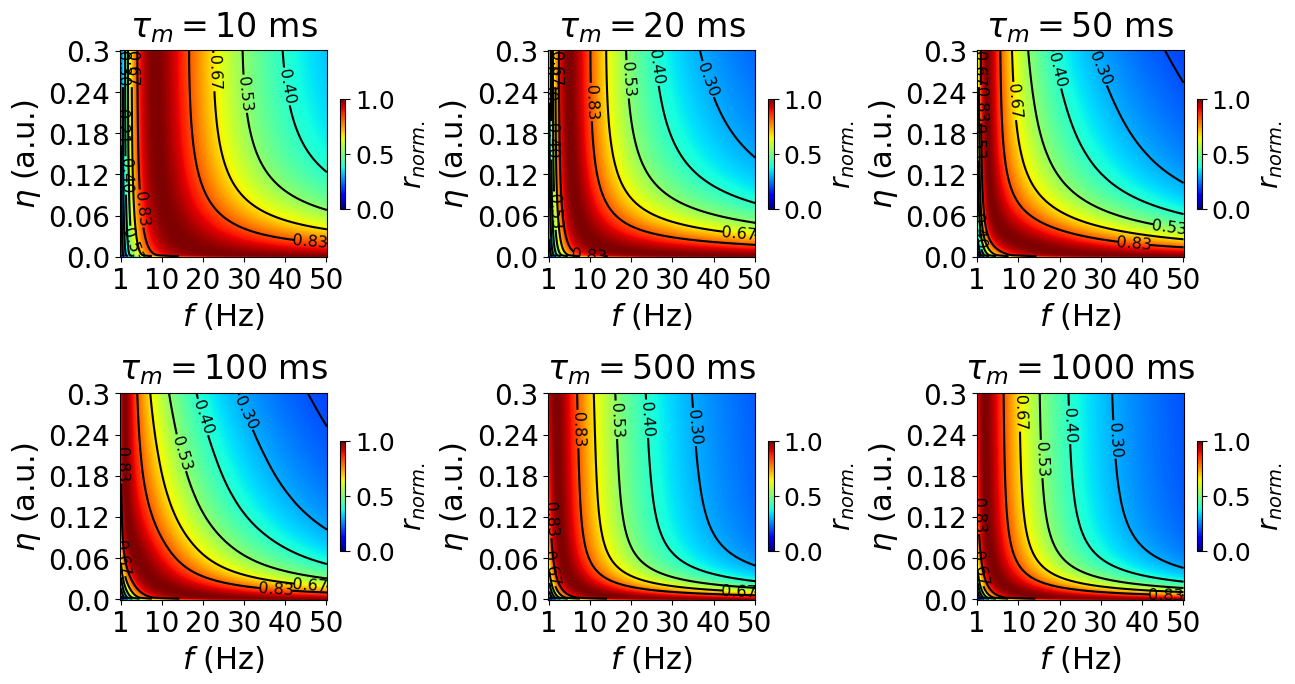

In [28]:
# Determine the common color scale range
vmin = 0
vmax = 1

# Define contour levels using a power law
num_levels = 12
power = 2  # Adjust power to control spacing between levels
contour_levels = np.linspace(0, 1, num=num_levels)**power * (vmax - vmin) + vmin

plt.figure(figsize=(13, 7))

for i, tau_m in enumerate(taus_m):
    plt.subplot(2,3,i+1)
    plt.title(r'$\tau_m=$'+str(int(tau_m*1e3))+' ms', fontsize=24, pad=10)
    img1 = plt.imshow(info_rate_theo_norm_taus_m[i], origin='lower', cmap='jet', vmin=vmin, vmax=vmax, interpolation='lanczos')
    contours1 = plt.contour(info_rate_theo_norm_taus_m[i], levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
    plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
    plt.xticks(np.linspace(0, res-1, 6), np.linspace(f_lims[0], f_lims[1], 6).astype(int), fontsize=20)
    plt.yticks(np.linspace(0, res-1, 6), np.linspace(eta_lims[0], eta_lims[1], 6).round(2), fontsize=20)
    plt.xlabel('$f$ (Hz)', fontsize=22)
    plt.ylabel('$\eta$ (a.u.)', fontsize=22)
    cbar = plt.colorbar(img1, label=r'$r_{norm.}$', shrink=.5)
    cbar.set_label(r'$r_{norm.}$', fontsize=20)
    cbar.ax.tick_params(labelsize=18)  # Increase colorbar tick fontsize

plt.tight_layout()

# Save the figure
plt.savefig('plots/fig6/supplFig6_R_taus_m.svg', dpi=600)

# Show the plot
plt.show()

### tau_s x tau_m grid

In [ ]:
M = 10
res = 50
fs = np.linspace(f_lims[0], f_lims[1], res)
etas = np.linspace(eta_lims[0], eta_lims[1], res)

indx_min_eta = 33#67
indx_max_eta = 50#100

tau_min = 10 * 1e-3   
tau_max = 1000 * 1e-3 
res_taus = 200
tau_values = np.logspace(np.log10(tau_min), np.log10(tau_max), num=res_taus)
tau_m_grid, tau_s_grid = np.meshgrid(tau_values, tau_values)

optimal_fs = np.zeros((res_taus, res_taus))

for i, tau_m in enumerate(tau_values):
    for j, tau_s in enumerate(tau_values):
        print(i,j)
        mis_theo = np.zeros((res,res))
        for ii, eta in enumerate(etas):
            for jj, f in enumerate(fs):
                means, variances, _ = get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N=1)
                mis_theo[ii,jj] = approx_mi(means, variances)
        info_rate = get_R(mis_theo, fs, tau_s, corr=True, norm=True)
        optimal_fs[i,j] = np.mean(fs[np.argmax(info_rate[indx_min_eta:indx_max_eta], axis=1)])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


7 113
7 114
7 115
7 116
7 117
7 118
7 119
7 120
7 121
7 122
7 123
7 124
7 125
7 126
7 127
7 128
7 129
7 130
7 131
7 132
7 133
7 134
7 135
7 136
7 137
7 138
7 139
7 140
7 141
7 142
7 143
7 144
7 145
7 146
7 147
7 148
7 149
7 150
7 151
7 152
7 153
7 154
7 155
7 156
7 157
7 158
7 159
7 160
7 161
7 162
7 163
7 164
7 165
7 166
7 167
7 168
7 169
7 170
7 171
7 172
7 173
7 174
7 175
7 176
7 177
7 178
7 179
7 180
7 181
7 182
7 183
7 184
7 185
7 186
7 187
7 188
7 189
7 190
7 191
7 192
7 193
7 194
7 195
7 196
7 197
7 198
7 199
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
8 20
8 21
8 22
8 23
8 24
8 25
8 26
8 27
8 28
8 29
8 30
8 31
8 32
8 33
8 34
8 35
8 36
8 37
8 38
8 39
8 40
8 41
8 42
8 43
8 44
8 45
8 46
8 47
8 48
8 49
8 50
8 51
8 52
8 53
8 54
8 55
8 56
8 57
8 58
8 59
8 60
8 61
8 62
8 63
8 64
8 65
8 66
8 67
8 68
8 69
8 70
8 71
8 72
8 73
8 74
8 75
8 76
8 77
8 78
8 79
8 80
8 81
8 82
8 83
8 84
8 85
8 86
8 87
8 88
8 89
8 90
8 91
8 92
8 93
8 94
8 95
8 96
8 9

14 57
14 58
14 59
14 60
14 61
14 62
14 63
14 64
14 65
14 66
14 67
14 68
14 69
14 70
14 71
14 72
14 73
14 74
14 75
14 76
14 77
14 78
14 79
14 80
14 81
14 82
14 83
14 84
14 85
14 86
14 87
14 88
14 89
14 90
14 91
14 92
14 93
14 94
14 95
14 96
14 97
14 98
14 99
14 100
14 101
14 102
14 103
14 104
14 105
14 106
14 107
14 108
14 109
14 110
14 111
14 112
14 113
14 114
14 115
14 116
14 117
14 118
14 119
14 120
14 121
14 122
14 123
14 124
14 125
14 126
14 127
14 128
14 129
14 130
14 131
14 132
14 133
14 134
14 135
14 136
14 137
14 138
14 139
14 140
14 141
14 142
14 143
14 144
14 145
14 146
14 147
14 148
14 149
14 150
14 151
14 152
14 153
14 154
14 155
14 156
14 157
14 158
14 159
14 160
14 161
14 162
14 163
14 164
14 165
14 166
14 167
14 168
14 169
14 170
14 171
14 172
14 173
14 174
14 175
14 176
14 177
14 178
14 179
14 180
14 181
14 182
14 183
14 184
14 185
14 186
14 187
14 188
14 189
14 190
14 191
14 192
14 193
14 194
14 195
14 196
14 197
14 198
14 199
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15

20 128
20 129
20 130
20 131
20 132
20 133
20 134
20 135
20 136
20 137
20 138
20 139
20 140
20 141
20 142
20 143
20 144
20 145
20 146
20 147
20 148
20 149
20 150
20 151
20 152
20 153
20 154
20 155
20 156
20 157
20 158
20 159
20 160
20 161
20 162
20 163
20 164
20 165
20 166
20 167
20 168
20 169
20 170
20 171
20 172
20 173
20 174
20 175
20 176
20 177
20 178
20 179
20 180
20 181
20 182
20 183
20 184
20 185
20 186
20 187
20 188
20 189
20 190
20 191
20 192
20 193
20 194
20 195
20 196
20 197
20 198
20 199
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9
21 10
21 11
21 12
21 13
21 14
21 15
21 16
21 17
21 18
21 19
21 20
21 21
21 22
21 23
21 24
21 25
21 26
21 27
21 28
21 29
21 30
21 31
21 32
21 33
21 34
21 35
21 36
21 37
21 38
21 39
21 40
21 41
21 42
21 43
21 44
21 45
21 46
21 47
21 48
21 49
21 50
21 51
21 52
21 53
21 54
21 55
21 56
21 57
21 58
21 59
21 60
21 61
21 62
21 63
21 64
21 65
21 66
21 67
21 68
21 69
21 70
21 71
21 72
21 73
21 74
21 75
21 76
21 77
21 78
21 79
21 80
21 81
21 82
21 83
21

26 193
26 194
26 195
26 196
26 197
26 198
26 199
27 0
27 1
27 2
27 3
27 4
27 5
27 6
27 7
27 8
27 9
27 10
27 11
27 12
27 13
27 14
27 15
27 16
27 17
27 18
27 19
27 20
27 21
27 22
27 23
27 24
27 25
27 26
27 27
27 28
27 29
27 30
27 31
27 32
27 33
27 34
27 35
27 36
27 37
27 38
27 39
27 40
27 41
27 42
27 43
27 44
27 45
27 46
27 47
27 48
27 49
27 50
27 51
27 52
27 53
27 54
27 55
27 56
27 57
27 58
27 59
27 60
27 61
27 62
27 63
27 64
27 65
27 66
27 67
27 68
27 69
27 70
27 71
27 72
27 73
27 74
27 75
27 76
27 77
27 78
27 79
27 80
27 81
27 82
27 83
27 84
27 85
27 86
27 87
27 88
27 89
27 90
27 91
27 92
27 93
27 94
27 95
27 96
27 97
27 98
27 99
27 100
27 101
27 102
27 103
27 104
27 105
27 106
27 107
27 108
27 109
27 110
27 111
27 112
27 113
27 114
27 115
27 116
27 117
27 118
27 119
27 120
27 121
27 122
27 123
27 124
27 125
27 126
27 127
27 128
27 129
27 130
27 131
27 132
27 133
27 134
27 135
27 136
27 137
27 138
27 139
27 140
27 141
27 142
27 143
27 144
27 145
27 146
27 147
27 148
27 149
27 150
27 1

33 69
33 70
33 71
33 72
33 73
33 74
33 75
33 76
33 77
33 78
33 79
33 80
33 81
33 82
33 83
33 84
33 85
33 86
33 87
33 88
33 89
33 90
33 91
33 92
33 93
33 94
33 95
33 96
33 97
33 98
33 99
33 100
33 101
33 102
33 103
33 104
33 105
33 106
33 107
33 108
33 109
33 110
33 111
33 112
33 113
33 114
33 115
33 116
33 117
33 118
33 119
33 120
33 121
33 122
33 123
33 124
33 125
33 126
33 127
33 128
33 129
33 130
33 131
33 132
33 133
33 134
33 135
33 136
33 137
33 138
33 139
33 140
33 141
33 142
33 143
33 144
33 145
33 146
33 147
33 148
33 149
33 150
33 151
33 152
33 153
33 154
33 155
33 156
33 157
33 158
33 159
33 160
33 161
33 162
33 163
33 164
33 165
33 166
33 167
33 168
33 169
33 170
33 171
33 172
33 173
33 174
33 175
33 176
33 177
33 178
33 179
33 180
33 181
33 182
33 183
33 184
33 185
33 186
33 187
33 188
33 189
33 190
33 191
33 192
33 193
33 194
33 195
33 196
33 197
33 198
33 199
34 0
34 1
34 2
34 3
34 4
34 5
34 6
34 7
34 8
34 9
34 10
34 11
34 12
34 13
34 14
34 15
34 16
34 17
34 18
34 19
34 2

39 139
39 140
39 141
39 142
39 143
39 144
39 145
39 146
39 147
39 148
39 149
39 150
39 151
39 152
39 153
39 154
39 155
39 156
39 157
39 158
39 159
39 160
39 161
39 162
39 163
39 164
39 165
39 166
39 167
39 168
39 169
39 170
39 171
39 172
39 173
39 174
39 175
39 176
39 177
39 178
39 179
39 180
39 181
39 182
39 183
39 184
39 185
39 186
39 187
39 188
39 189
39 190
39 191
39 192
39 193
39 194
39 195
39 196
39 197
39 198
39 199
40 0
40 1
40 2
40 3
40 4
40 5
40 6
40 7
40 8
40 9
40 10
40 11
40 12
40 13
40 14
40 15
40 16
40 17
40 18
40 19
40 20
40 21
40 22
40 23
40 24
40 25
40 26
40 27
40 28
40 29
40 30
40 31
40 32
40 33
40 34
40 35
40 36
40 37
40 38
40 39
40 40
40 41
40 42
40 43
40 44
40 45
40 46
40 47
40 48
40 49
40 50
40 51
40 52
40 53
40 54
40 55
40 56
40 57
40 58
40 59
40 60
40 61
40 62
40 63
40 64
40 65
40 66
40 67
40 68
40 69
40 70
40 71
40 72
40 73
40 74
40 75
40 76
40 77
40 78
40 79
40 80
40 81
40 82
40 83
40 84
40 85
40 86
40 87
40 88
40 89
40 90
40 91
40 92
40 93
40 94
40 95
40 96
4

46 6
46 7
46 8
46 9
46 10
46 11
46 12
46 13
46 14
46 15
46 16
46 17
46 18
46 19
46 20
46 21
46 22
46 23
46 24
46 25
46 26
46 27
46 28
46 29
46 30
46 31
46 32
46 33
46 34
46 35
46 36
46 37
46 38
46 39
46 40
46 41
46 42
46 43
46 44
46 45
46 46
46 47
46 48
46 49
46 50
46 51
46 52
46 53
46 54
46 55
46 56
46 57
46 58
46 59
46 60
46 61
46 62
46 63
46 64
46 65
46 66
46 67
46 68
46 69
46 70
46 71
46 72
46 73
46 74
46 75
46 76
46 77
46 78
46 79
46 80
46 81
46 82
46 83
46 84
46 85
46 86
46 87
46 88
46 89
46 90
46 91
46 92
46 93
46 94
46 95
46 96
46 97
46 98
46 99
46 100
46 101
46 102
46 103
46 104
46 105
46 106
46 107
46 108
46 109
46 110
46 111
46 112
46 113
46 114
46 115
46 116
46 117
46 118
46 119
46 120
46 121
46 122
46 123
46 124
46 125
46 126
46 127
46 128
46 129
46 130
46 131
46 132
46 133
46 134
46 135
46 136
46 137
46 138
46 139
46 140
46 141
46 142
46 143
46 144
46 145
46 146
46 147
46 148
46 149
46 150
46 151
46 152
46 153
46 154
46 155
46 156
46 157
46 158
46 159
46 160
46 161
46 162

52 83
52 84
52 85
52 86
52 87
52 88
52 89
52 90
52 91
52 92
52 93
52 94
52 95
52 96
52 97
52 98
52 99
52 100
52 101
52 102
52 103
52 104
52 105
52 106
52 107
52 108
52 109
52 110
52 111
52 112
52 113
52 114
52 115
52 116
52 117
52 118
52 119
52 120
52 121
52 122
52 123
52 124
52 125
52 126
52 127
52 128
52 129
52 130
52 131
52 132
52 133
52 134
52 135
52 136
52 137
52 138
52 139
52 140
52 141
52 142
52 143
52 144
52 145
52 146
52 147
52 148
52 149
52 150
52 151
52 152
52 153
52 154
52 155
52 156
52 157
52 158
52 159
52 160
52 161
52 162
52 163
52 164
52 165
52 166
52 167
52 168
52 169
52 170
52 171
52 172
52 173
52 174
52 175
52 176
52 177
52 178
52 179
52 180
52 181
52 182
52 183
52 184
52 185
52 186
52 187
52 188
52 189
52 190
52 191
52 192
52 193
52 194
52 195
52 196
52 197
52 198
52 199
53 0
53 1
53 2
53 3
53 4
53 5
53 6
53 7
53 8
53 9
53 10
53 11
53 12
53 13
53 14
53 15
53 16
53 17
53 18
53 19
53 20
53 21
53 22
53 23
53 24
53 25
53 26
53 27
53 28
53 29
53 30
53 31
53 32
53 33
53 3

58 151
58 152
58 153
58 154
58 155
58 156
58 157
58 158
58 159
58 160
58 161
58 162
58 163
58 164
58 165
58 166
58 167
58 168
58 169
58 170
58 171
58 172
58 173
58 174
58 175
58 176
58 177
58 178
58 179
58 180
58 181
58 182
58 183
58 184
58 185
58 186
58 187
58 188
58 189
58 190
58 191
58 192
58 193
58 194
58 195
58 196
58 197
58 198
58 199
59 0
59 1
59 2
59 3
59 4
59 5
59 6
59 7
59 8
59 9
59 10
59 11
59 12
59 13
59 14
59 15
59 16
59 17
59 18
59 19
59 20
59 21
59 22
59 23
59 24
59 25
59 26
59 27
59 28
59 29
59 30
59 31
59 32
59 33
59 34
59 35
59 36
59 37
59 38
59 39
59 40
59 41
59 42
59 43
59 44
59 45
59 46
59 47
59 48
59 49
59 50
59 51
59 52
59 53
59 54
59 55
59 56
59 57
59 58
59 59
59 60
59 61
59 62
59 63
59 64
59 65
59 66
59 67
59 68
59 69
59 70
59 71
59 72
59 73
59 74
59 75
59 76
59 77
59 78
59 79
59 80
59 81
59 82
59 83
59 84
59 85
59 86
59 87
59 88
59 89
59 90
59 91
59 92
59 93
59 94
59 95
59 96
59 97
59 98
59 99
59 100
59 101
59 102
59 103
59 104
59 105
59 106
59 107
59 108
59 1

65 20
65 21
65 22
65 23
65 24
65 25
65 26
65 27
65 28
65 29
65 30
65 31
65 32
65 33
65 34
65 35
65 36
65 37
65 38
65 39
65 40
65 41
65 42
65 43
65 44
65 45
65 46
65 47
65 48
65 49
65 50
65 51
65 52
65 53
65 54
65 55
65 56
65 57
65 58
65 59
65 60
65 61
65 62
65 63
65 64
65 65
65 66
65 67
65 68
65 69
65 70
65 71
65 72
65 73
65 74
65 75
65 76
65 77
65 78
65 79
65 80
65 81
65 82
65 83
65 84
65 85
65 86
65 87
65 88
65 89
65 90
65 91
65 92
65 93
65 94
65 95
65 96
65 97
65 98
65 99
65 100
65 101
65 102
65 103
65 104
65 105
65 106
65 107
65 108
65 109
65 110
65 111
65 112
65 113
65 114
65 115
65 116
65 117
65 118
65 119
65 120
65 121
65 122
65 123
65 124
65 125
65 126
65 127
65 128
65 129
65 130
65 131
65 132
65 133
65 134
65 135
65 136
65 137
65 138
65 139
65 140
65 141
65 142
65 143
65 144
65 145
65 146
65 147
65 148
65 149
65 150
65 151
65 152
65 153
65 154
65 155
65 156
65 157
65 158
65 159
65 160
65 161
65 162
65 163
65 164
65 165
65 166
65 167
65 168
65 169
65 170
65 171
65 172
65 173
65

71 96
71 97
71 98
71 99
71 100
71 101
71 102
71 103
71 104
71 105
71 106
71 107
71 108
71 109
71 110
71 111
71 112
71 113
71 114
71 115
71 116
71 117
71 118
71 119
71 120
71 121
71 122
71 123
71 124
71 125
71 126
71 127
71 128
71 129
71 130
71 131
71 132
71 133
71 134
71 135
71 136
71 137
71 138
71 139
71 140
71 141
71 142
71 143
71 144
71 145
71 146
71 147
71 148
71 149
71 150
71 151
71 152
71 153
71 154
71 155
71 156
71 157
71 158
71 159
71 160
71 161
71 162
71 163
71 164
71 165
71 166
71 167
71 168
71 169
71 170
71 171
71 172
71 173
71 174
71 175
71 176
71 177
71 178
71 179
71 180
71 181
71 182
71 183
71 184
71 185
71 186
71 187
71 188
71 189
71 190
71 191
71 192
71 193
71 194
71 195
71 196
71 197
71 198
71 199
72 0
72 1
72 2
72 3
72 4
72 5
72 6
72 7
72 8
72 9
72 10
72 11
72 12
72 13
72 14
72 15
72 16
72 17
72 18
72 19
72 20
72 21
72 22
72 23
72 24
72 25
72 26
72 27
72 28
72 29
72 30
72 31
72 32
72 33
72 34
72 35
72 36
72 37
72 38
72 39
72 40
72 41
72 42
72 43
72 44
72 45
72 46
72 4

77 162
77 163
77 164
77 165
77 166
77 167
77 168
77 169
77 170
77 171
77 172
77 173
77 174
77 175
77 176
77 177
77 178
77 179
77 180
77 181
77 182
77 183
77 184
77 185
77 186
77 187
77 188
77 189
77 190
77 191
77 192
77 193
77 194
77 195
77 196
77 197
77 198
77 199
78 0
78 1
78 2
78 3
78 4
78 5
78 6
78 7
78 8
78 9
78 10
78 11
78 12
78 13
78 14
78 15
78 16
78 17
78 18
78 19
78 20
78 21
78 22
78 23
78 24
78 25
78 26
78 27
78 28
78 29
78 30
78 31
78 32
78 33
78 34
78 35
78 36
78 37
78 38
78 39
78 40
78 41
78 42
78 43
78 44
78 45
78 46
78 47
78 48
78 49
78 50
78 51
78 52
78 53
78 54
78 55
78 56
78 57
78 58
78 59
78 60
78 61
78 62
78 63
78 64
78 65
78 66
78 67
78 68
78 69
78 70
78 71
78 72
78 73
78 74
78 75
78 76
78 77
78 78
78 79
78 80
78 81
78 82
78 83
78 84
78 85
78 86
78 87
78 88
78 89
78 90
78 91
78 92
78 93
78 94
78 95
78 96
78 97
78 98
78 99
78 100
78 101
78 102
78 103
78 104
78 105
78 106
78 107
78 108
78 109
78 110
78 111
78 112
78 113
78 114
78 115
78 116
78 117
78 118
78 119
78 1

84 33
84 34
84 35
84 36
84 37
84 38
84 39
84 40
84 41
84 42
84 43
84 44
84 45
84 46
84 47
84 48
84 49
84 50
84 51
84 52
84 53
84 54
84 55
84 56
84 57
84 58
84 59
84 60
84 61
84 62
84 63
84 64
84 65
84 66
84 67
84 68
84 69
84 70
84 71
84 72
84 73
84 74
84 75
84 76
84 77
84 78
84 79
84 80
84 81
84 82
84 83
84 84
84 85
84 86
84 87
84 88
84 89
84 90
84 91
84 92
84 93
84 94
84 95
84 96
84 97
84 98
84 99
84 100
84 101
84 102
84 103
84 104
84 105
84 106
84 107
84 108
84 109
84 110
84 111
84 112
84 113
84 114
84 115
84 116
84 117
84 118
84 119
84 120
84 121
84 122
84 123
84 124
84 125
84 126
84 127
84 128
84 129
84 130
84 131
84 132
84 133
84 134
84 135
84 136
84 137
84 138
84 139
84 140
84 141
84 142
84 143
84 144
84 145
84 146
84 147
84 148
84 149
84 150
84 151
84 152
84 153
84 154
84 155
84 156
84 157
84 158
84 159
84 160
84 161
84 162
84 163
84 164
84 165
84 166
84 167
84 168
84 169
84 170
84 171
84 172
84 173
84 174
84 175
84 176
84 177
84 178
84 179
84 180
84 181
84 182
84 183
84 184
84 

90 108
90 109
90 110
90 111
90 112
90 113
90 114
90 115
90 116
90 117
90 118
90 119
90 120
90 121
90 122
90 123
90 124
90 125
90 126
90 127
90 128
90 129
90 130
90 131
90 132
90 133
90 134
90 135
90 136
90 137
90 138
90 139
90 140
90 141
90 142
90 143
90 144
90 145
90 146
90 147
90 148
90 149
90 150
90 151
90 152
90 153
90 154
90 155
90 156
90 157
90 158
90 159
90 160
90 161
90 162
90 163
90 164
90 165
90 166
90 167
90 168
90 169
90 170
90 171
90 172
90 173
90 174
90 175
90 176
90 177
90 178
90 179
90 180
90 181
90 182
90 183
90 184
90 185
90 186
90 187
90 188
90 189
90 190
90 191
90 192
90 193
90 194
90 195
90 196
90 197
90 198
90 199
91 0
91 1
91 2
91 3
91 4
91 5
91 6
91 7
91 8
91 9
91 10
91 11
91 12
91 13
91 14
91 15
91 16
91 17
91 18
91 19
91 20
91 21
91 22
91 23
91 24
91 25
91 26
91 27
91 28
91 29
91 30
91 31
91 32
91 33
91 34
91 35
91 36
91 37
91 38
91 39
91 40
91 41
91 42
91 43
91 44
91 45
91 46
91 47
91 48
91 49
91 50
91 51
91 52
91 53
91 54
91 55
91 56
91 57
91 58
91 59
91 60


96 173
96 174
96 175
96 176
96 177
96 178
96 179
96 180
96 181
96 182
96 183
96 184
96 185
96 186
96 187
96 188
96 189
96 190
96 191
96 192
96 193
96 194
96 195
96 196
96 197
96 198
96 199
97 0
97 1
97 2
97 3
97 4
97 5
97 6
97 7
97 8
97 9
97 10
97 11
97 12
97 13
97 14
97 15
97 16
97 17
97 18
97 19
97 20
97 21
97 22
97 23
97 24
97 25
97 26
97 27
97 28
97 29
97 30
97 31
97 32
97 33
97 34
97 35
97 36
97 37
97 38
97 39
97 40
97 41
97 42
97 43
97 44
97 45
97 46
97 47
97 48
97 49
97 50
97 51
97 52
97 53
97 54
97 55
97 56
97 57
97 58
97 59
97 60
97 61
97 62
97 63
97 64
97 65
97 66
97 67
97 68
97 69
97 70
97 71
97 72
97 73
97 74
97 75
97 76
97 77
97 78
97 79
97 80
97 81
97 82
97 83
97 84
97 85
97 86
97 87
97 88
97 89
97 90
97 91
97 92
97 93
97 94
97 95
97 96
97 97
97 98
97 99
97 100
97 101
97 102
97 103
97 104
97 105
97 106
97 107
97 108
97 109
97 110
97 111
97 112
97 113
97 114
97 115
97 116
97 117
97 118
97 119
97 120
97 121
97 122
97 123
97 124
97 125
97 126
97 127
97 128
97 129
97 130
97 1

102 158
102 159
102 160
102 161
102 162
102 163
102 164
102 165
102 166
102 167
102 168
102 169
102 170
102 171
102 172
102 173
102 174
102 175
102 176
102 177
102 178
102 179
102 180
102 181
102 182
102 183
102 184
102 185
102 186
102 187
102 188
102 189
102 190
102 191
102 192
102 193
102 194
102 195
102 196
102 197
102 198
102 199
103 0
103 1
103 2
103 3
103 4
103 5
103 6
103 7
103 8
103 9
103 10
103 11
103 12
103 13
103 14
103 15
103 16
103 17
103 18
103 19
103 20
103 21
103 22
103 23
103 24
103 25
103 26
103 27
103 28
103 29
103 30
103 31
103 32
103 33
103 34
103 35
103 36
103 37
103 38
103 39
103 40
103 41
103 42
103 43
103 44
103 45
103 46
103 47
103 48
103 49
103 50
103 51
103 52
103 53
103 54
103 55
103 56
103 57
103 58
103 59
103 60
103 61
103 62
103 63
103 64
103 65
103 66
103 67
103 68
103 69
103 70
103 71
103 72
103 73
103 74
103 75
103 76
103 77
103 78
103 79
103 80
103 81
103 82
103 83
103 84
103 85
103 86
103 87
103 88
103 89
103 90
103 91
103 92
103 93
103 94
103 95
10

108 60
108 61
108 62
108 63
108 64
108 65
108 66
108 67
108 68
108 69
108 70
108 71
108 72
108 73
108 74
108 75
108 76
108 77
108 78
108 79
108 80
108 81
108 82
108 83
108 84
108 85
108 86
108 87
108 88
108 89
108 90
108 91
108 92
108 93
108 94
108 95
108 96
108 97
108 98
108 99
108 100
108 101
108 102
108 103
108 104
108 105
108 106
108 107
108 108
108 109
108 110
108 111
108 112
108 113
108 114
108 115
108 116
108 117
108 118
108 119
108 120
108 121
108 122
108 123
108 124
108 125
108 126
108 127
108 128
108 129
108 130
108 131
108 132
108 133
108 134
108 135
108 136
108 137
108 138
108 139
108 140
108 141
108 142
108 143
108 144
108 145
108 146
108 147
108 148
108 149
108 150
108 151
108 152
108 153
108 154
108 155
108 156
108 157
108 158
108 159
108 160
108 161
108 162
108 163
108 164
108 165
108 166
108 167
108 168
108 169
108 170
108 171
108 172
108 173
108 174
108 175
108 176
108 177
108 178
108 179
108 180
108 181
108 182
108 183
108 184
108 185
108 186
108 187
108 188
108 189


In [ ]:
plt.figure(figsize=(6, 6), dpi=600)

# Simulations plot
plt.title('Optimal $f$', fontsize=24, pad=10)
img1 = plt.imshow(optimal_fs, origin='lower', cmap='jet', interpolation='lanczos')
contour_levels = np.logspace(np.log10(optimal_fs.min()), np.log10(optimal_fs.max()), num=20)
contours1 = plt.contour(optimal_fs, levels=contour_levels, colors='black', linewidths=1.5, origin='lower')
plt.clabel(contours1, inline=True, fontsize=11.5, fmt='%1.2f')  # Adding labels to contours
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\tau_{m}$ (ms)', fontsize=24)
plt.ylabel(r'$\tau_{s}$ (ms)', fontsize=24)
plt.xscale('log')
plt.yscale('log')
cbar = plt.colorbar(img1, shrink=.5)
cbar.set_label('$f$ (Hz)', fontsize=20)
cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick fontsize
plt.tight_layout()

#plt.savefig('plots/fig6/fig6_varianceEstim.svg', dpi=600)

plt.show()